In [1]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import numpy as np
import math
import time
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import regularizers
import re

AUTO = tf.data.experimental.AUTOTUNE

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.14.0


In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-11-12 20:37:16.099962: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:16.100066: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:16.100146: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:16.100238: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:16.100330: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:16.100525: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:16.100613: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [3]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started


In [4]:
IMAGE_SIZE = [192, 192] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 25
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
HEIGHT = 192
WIDTH = 192
CHANNELS = 3
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-192x192'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']  




In [5]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)


In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset


In [7]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    #dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [8]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()
test_dataset = get_test_dataset(ordered=True)

In [9]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in training_dataset.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

print("Test data shapes:")
for image, idnum in test_dataset.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
Training data label examples: [62 75 18 ... 56 75 21]
Test data shapes:
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
Test data IDs: ['6557acff6' '54f73d67c' '32b46db46' ... '39e216b40' '58c271df1' '246798d36']


In [10]:

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
    


In [11]:
#my code
model_names = []
model_training_time = []
def display_training_time_plot(model_names, model_training_time):
    plt.bar(model_names, model_training_time)
    plt.xlabel('models')
    plt.ylabel('training time')
    plt.xticks(rotation=90)
    plt.title("Training Time of  different models")
    plt.show()

train_accuracy = []
val_accuracy = []


def display_accuracy_plot(model_names, train_accuracy, val_accuracy):
    fig, ax = plt.subplots()
    ax.plot(model_names, train_accuracy)
    ax.plot(model_names, val_accuracy)
    plt.xticks(rotation=90)
    ax.legend(['train', 'valid.'])
    plt.show()

2023-11-12 20:37:22.833587: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:22.833704: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 256)       147712    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 512)       1180160   
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 512)       0

2023-11-12 20:37:31.212730: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:31.231105: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:31.249968: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:31.269885: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:31.288372: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:31.306662: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:31.324729: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 1/99 [..............................] - ETA: 21:59 - loss: 4.6413 - sparse_categorical_accuracy: 0.0312

2023-11-12 20:37:44.702879: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:44.702977: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:44.703066: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:44.703267: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:44.703357: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:44.703440: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-12 20:37:44.703537: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 4/99 [>.............................] - ETA: 14s - loss: 13.4746 - sparse_categorical_accuracy: 0.0352

2023-11-12 20:37:45.108375: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


99/99 [==============================] - 32s 192ms/step - loss: 4.2819 - sparse_categorical_accuracy: 0.1082 - val_loss: 3.3189 - val_sparse_categorical_accuracy: 0.1678
Epoch 2/25
99/99 [==============================] - 12s 125ms/step - loss: 3.2144 - sparse_categorical_accuracy: 0.1978 - val_loss: 3.0059 - val_sparse_categorical_accuracy: 0.2309
Epoch 3/25
99/99 [==============================] - 12s 126ms/step - loss: 2.8826 - sparse_categorical_accuracy: 0.2621 - val_loss: 2.7496 - val_sparse_categorical_accuracy: 0.2810
Epoch 4/25
99/99 [==============================] - 12s 125ms/step - loss: 2.5145 - sparse_categorical_accuracy: 0.3408 - val_loss: 2.5810 - val_sparse_categorical_accuracy: 0.3257
Epoch 5/25
99/99 [==============================] - 13s 128ms/step - loss: 2.0797 - sparse_categorical_accuracy: 0.4437 - val_loss: 2.5641 - val_sparse_categorical_accuracy: 0.3594
Epoch 6/25
99/99 [==============================] - 12s 125ms/step - loss: 1.6490 - sparse_categorical_acc

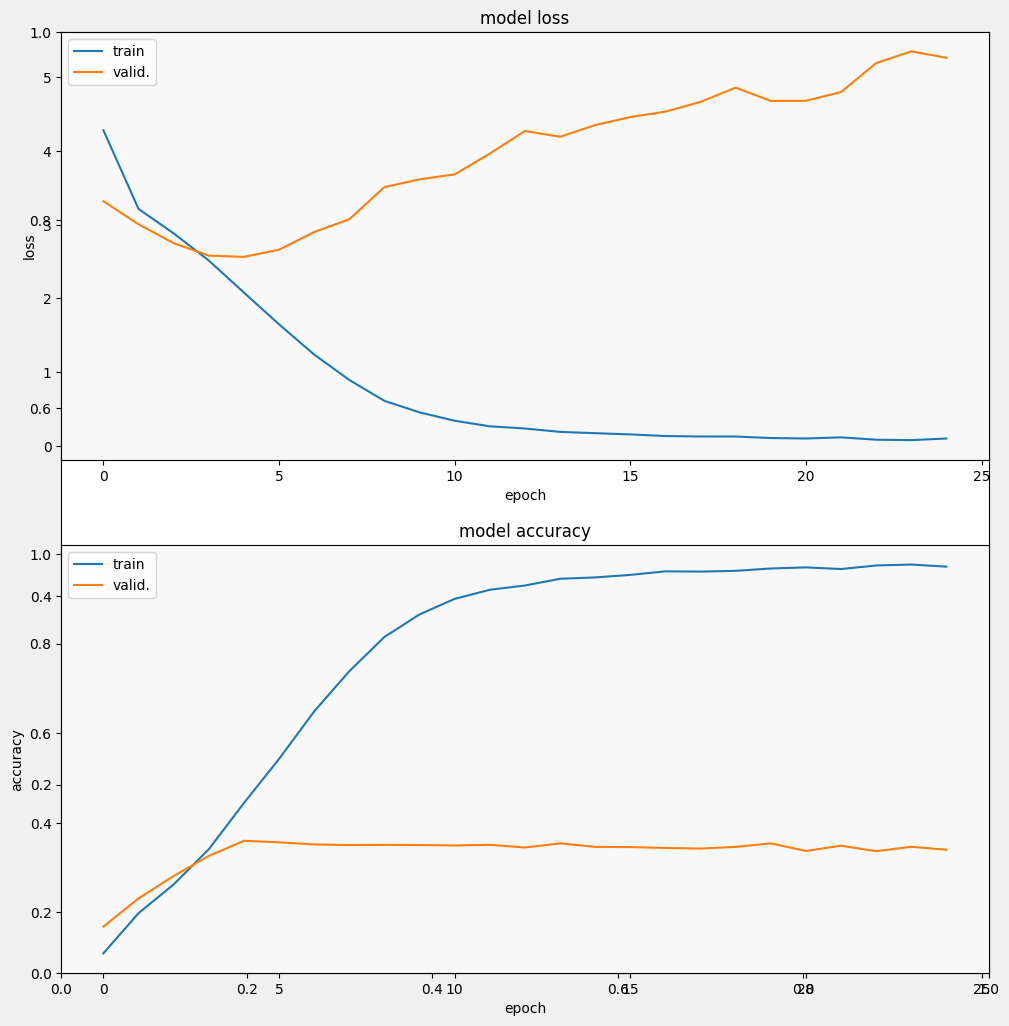

In [12]:
#my code; the model defination is original
with strategy.scope():    
    
    # Define the model as a sequential sequence of layers
    model1 = Sequential()

    # Define convolutional layers
    model1.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(*IMAGE_SIZE, 3)))
    model1.add(MaxPooling2D((2, 2)))

    model1.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model1.add(MaxPooling2D((2, 2)))
    
    model1.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model1.add(MaxPooling2D((2, 2)))


    # Define classification layers
    model1.add(Flatten())
    model1.add(Dense(1024, activation='relu'))
    model1.add(Dropout(0.5))
    model1.add(Dense(len(CLASSES), activation='softmax'))

    # Print a summary of the model architecture
    print(model1.summary())

      
model1.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


start_time = time.time()
model1_history = model1.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset)
end_time = time.time()
model_training_time.append(end_time-start_time)
model_names.append('model1')

display_training_curves(
    model1_history.history['loss'],
    model1_history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    model1_history.history['sparse_categorical_accuracy'],
    model1_history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

train_accuracy.append(model1_history.history['sparse_categorical_accuracy'][-1])
val_accuracy.append(model1_history.history['val_sparse_categorical_accuracy'][-1])

The training accuracy is 97.43% and validation accuracy is 33.35%, which is a strong indication that the model is overfitted. 
https://www.analyticsvidhya.com/blog/2020/09/overfitting-in-cnn-show-to-treat-overfitting-in-convolutional-neural-networks/
Overfitting can be resolved using following 
* Regularization
* Weight Initialization
* Dropout Regularization
* Weight Constraints

Below I have added L2 Regularization to the hidden layers 2 and 3

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 192, 192, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 96, 96, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 256)       147712    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 48, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 512)       1180160   
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 512)      

2023-11-12 20:43:17.255992: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


99/99 [==============================] - 31s 183ms/step - loss: 5.6852 - sparse_categorical_accuracy: 0.1130 - val_loss: 4.2341 - val_sparse_categorical_accuracy: 0.1821
Epoch 2/25
99/99 [==============================] - 12s 125ms/step - loss: 3.9465 - sparse_categorical_accuracy: 0.1940 - val_loss: 3.4882 - val_sparse_categorical_accuracy: 0.2303
Epoch 3/25
99/99 [==============================] - 12s 125ms/step - loss: 3.3946 - sparse_categorical_accuracy: 0.2439 - val_loss: 3.1744 - val_sparse_categorical_accuracy: 0.2605
Epoch 4/25
99/99 [==============================] - 12s 126ms/step - loss: 3.0663 - sparse_categorical_accuracy: 0.2838 - val_loss: 2.9045 - val_sparse_categorical_accuracy: 0.3101
Epoch 5/25
99/99 [==============================] - 12s 126ms/step - loss: 2.7931 - sparse_categorical_accuracy: 0.3224 - val_loss: 2.7833 - val_sparse_categorical_accuracy: 0.3171
Epoch 6/25
99/99 [==============================] - 12s 125ms/step - loss: 2.5915 - sparse_categorical_acc

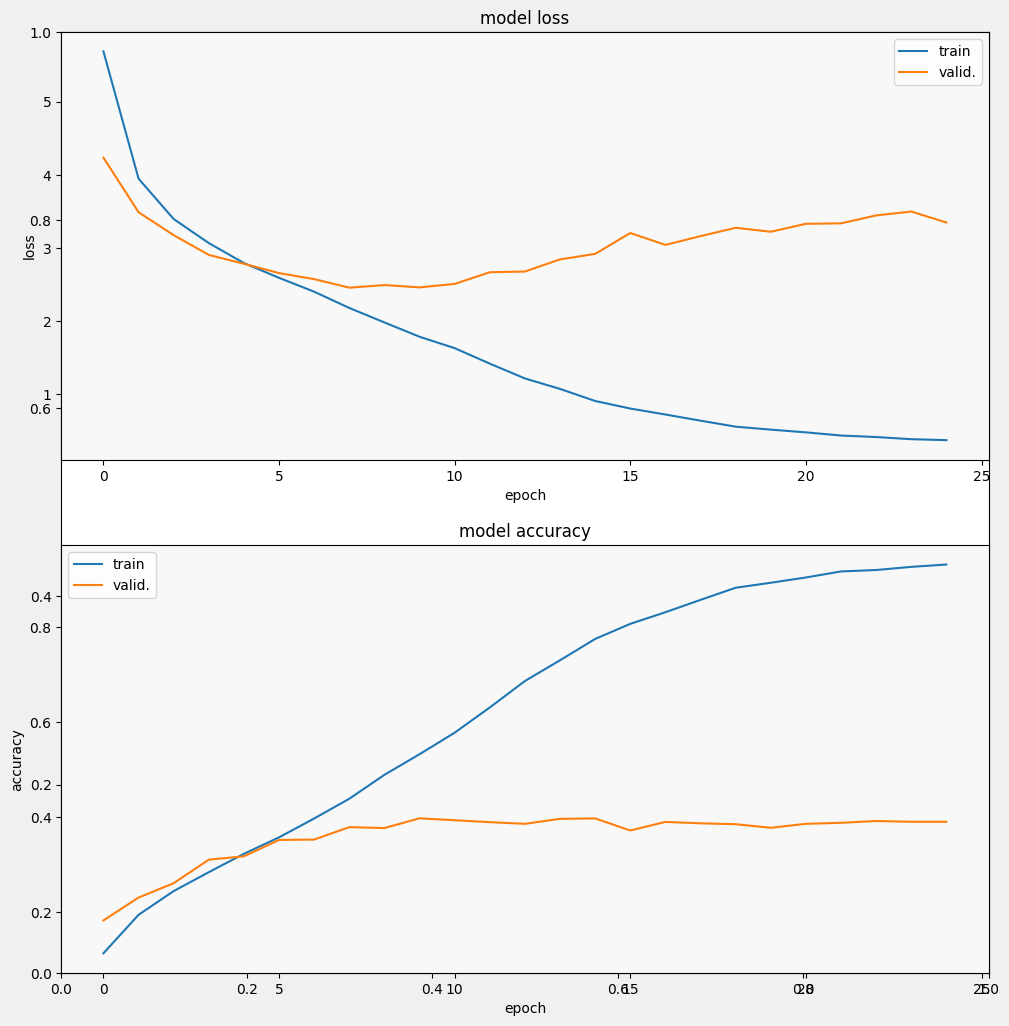

In [13]:
#my code; the model defination is original
with strategy.scope():    
    
    # Define the model as a sequential sequence of layers
    model1_regularization = Sequential()

    # Define convolutional layers
    model1_regularization.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(*IMAGE_SIZE, 3)))
    model1_regularization.add(MaxPooling2D((2, 2)))

    model1_regularization.add(Conv2D(256, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(l=0.01), padding='same'))
    model1_regularization.add(MaxPooling2D((2, 2)))
    
    model1_regularization.add(Conv2D(512, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.01),padding='same'))
    model1_regularization.add(MaxPooling2D((2, 2)))


    # Define classification layers
    model1_regularization.add(Flatten())
    model1_regularization.add(Dense(1024, activation='relu'))
    model1_regularization.add(Dropout(0.5))
    model1_regularization.add(Dense(len(CLASSES), activation='softmax'))

    # Print a summary of the model architecture
    print(model1_regularization.summary())

      
model1_regularization.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


start_time = time.time()
model1_regularization_history = model1_regularization.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset)
end_time = time.time()
model_training_time.append(end_time-start_time)
model_names.append('model1_regularization')

display_training_curves(
    model1_regularization_history.history['loss'],
    model1_regularization_history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    model1_regularization_history.history['sparse_categorical_accuracy'],
    model1_regularization_history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

train_accuracy.append(model1_regularization_history.history['sparse_categorical_accuracy'][-1])
val_accuracy.append(model1_regularization_history.history['val_sparse_categorical_accuracy'][-1])

Addition of L2 Regularizer to layer 2 and layer 3 led to the increase in the validation accuracy. Althought there is an increase in accuracy for validation data set. It still appears that the model is overfitting to the training data.


Next we build a more complex CNN model with more convolution layers.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 192, 192, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 96, 96, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 96, 256)       147712    
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 256)       590080    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 48, 48, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 512)      

2023-11-12 20:48:54.320117: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


99/99 [==============================] - 38s 204ms/step - loss: 4.9770 - sparse_categorical_accuracy: 0.0548 - val_loss: 4.1685 - val_sparse_categorical_accuracy: 0.0614
Epoch 2/25
99/99 [==============================] - 13s 136ms/step - loss: 4.1320 - sparse_categorical_accuracy: 0.0634 - val_loss: 3.9105 - val_sparse_categorical_accuracy: 0.0803
Epoch 3/25
99/99 [==============================] - 14s 140ms/step - loss: 3.8720 - sparse_categorical_accuracy: 0.0910 - val_loss: 3.7774 - val_sparse_categorical_accuracy: 0.1153
Epoch 4/25
99/99 [==============================] - 14s 137ms/step - loss: 3.7156 - sparse_categorical_accuracy: 0.1199 - val_loss: 3.5725 - val_sparse_categorical_accuracy: 0.1509
Epoch 5/25
99/99 [==============================] - 13s 135ms/step - loss: 3.5504 - sparse_categorical_accuracy: 0.1541 - val_loss: 3.4142 - val_sparse_categorical_accuracy: 0.1713
Epoch 6/25
99/99 [==============================] - 13s 136ms/step - loss: 3.3337 - sparse_categorical_acc

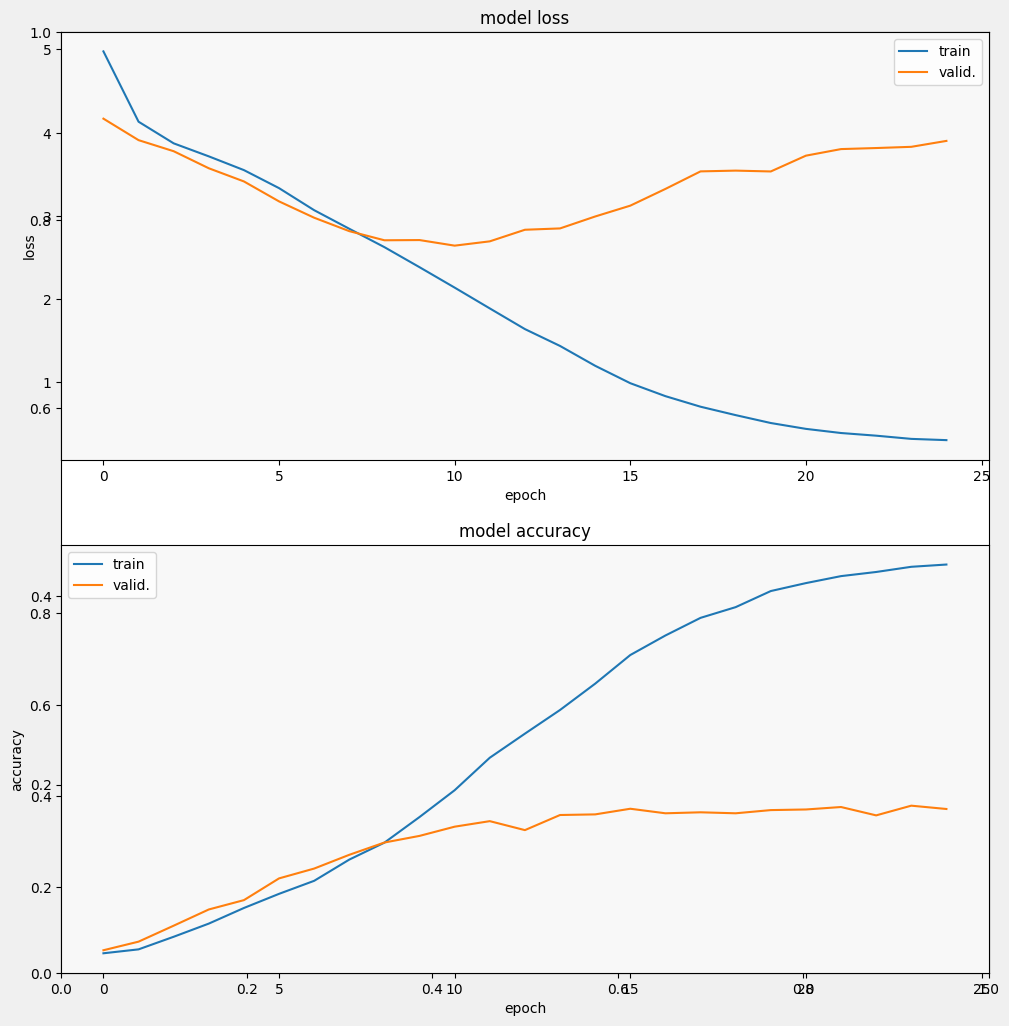

In [14]:
#my code; the model defination is original
with strategy.scope():    
    
    # Define the model as a sequential sequence of layers
    model2 = Sequential()

    # Define convolutional layers
    model2.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(*IMAGE_SIZE, 3)))
    model2.add(MaxPooling2D((2, 2)))

    model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model2.add(MaxPooling2D((2, 2)))
    
    model2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model2.add(MaxPooling2D((2, 2)))
    
    model2.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
    model2.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
    model2.add(MaxPooling2D((2, 2)))
    


    # Define classification layers
    model2.add(Flatten())
    model2.add(Dense(1024, activation='relu'))
    model2.add(Dropout(0.4))
    model2.add(Dense(512, activation='relu'))
    model2.add(Dropout(0.2))
    model2.add(Dense(len(CLASSES), activation='softmax'))

    # Print a summary of the model architecture
    print(model2.summary())

      
model2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


start_time = time.time()
model2_history = model2.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset)
end_time = time.time()
model_training_time.append(end_time-start_time)
model_names.append('model2')

display_training_curves(
    model2_history.history['loss'],
    model2_history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    model2_history.history['sparse_categorical_accuracy'],
    model2_history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

train_accuracy.append(model2_history.history['sparse_categorical_accuracy'][-1])
val_accuracy.append(model2_history.history['val_sparse_categorical_accuracy'][-1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 192, 192, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 96, 96, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 96, 96, 256)       147712    
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 96, 256)       590080    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 48, 48, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 512)      

2023-11-12 20:55:03.524069: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


99/99 [==============================] - 38s 198ms/step - loss: 6.8861 - sparse_categorical_accuracy: 0.0540 - val_loss: 4.5643 - val_sparse_categorical_accuracy: 0.0614
Epoch 2/25
99/99 [==============================] - 13s 135ms/step - loss: 4.3320 - sparse_categorical_accuracy: 0.0705 - val_loss: 4.0745 - val_sparse_categorical_accuracy: 0.0881
Epoch 3/25
99/99 [==============================] - 13s 136ms/step - loss: 3.9961 - sparse_categorical_accuracy: 0.1002 - val_loss: 3.8395 - val_sparse_categorical_accuracy: 0.1210
Epoch 4/25
99/99 [==============================] - 13s 136ms/step - loss: 3.7747 - sparse_categorical_accuracy: 0.1280 - val_loss: 3.6485 - val_sparse_categorical_accuracy: 0.1371
Epoch 5/25
99/99 [==============================] - 13s 136ms/step - loss: 3.6092 - sparse_categorical_accuracy: 0.1424 - val_loss: 3.5291 - val_sparse_categorical_accuracy: 0.1546
Epoch 6/25
99/99 [==============================] - 14s 137ms/step - loss: 3.4199 - sparse_categorical_acc

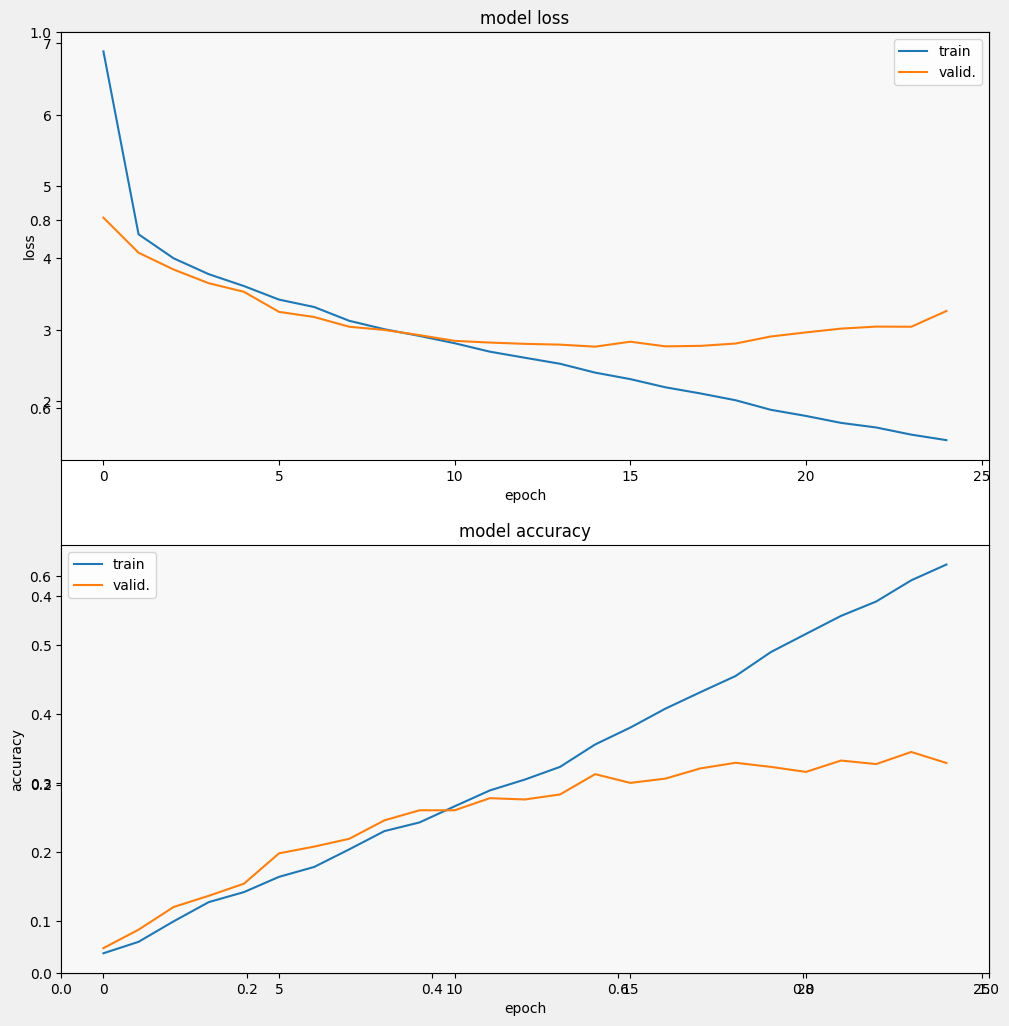

In [15]:
#my code; the model defination is original
with strategy.scope():    
    
    # Define the model as a sequential sequence of layers
    model2_regularization = Sequential()

    # Define convolutional layers
    model2_regularization.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(*IMAGE_SIZE, 3)))
    model2_regularization.add(MaxPooling2D((2, 2)))

    model2_regularization.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.01), padding='same'))
    model2_regularization.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.01), padding='same'))
    model2_regularization.add(MaxPooling2D((2, 2)))
    
    model2_regularization.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model2_regularization.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model2_regularization.add(MaxPooling2D((2, 2)))
    
    model2_regularization.add(Conv2D(1024, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.01),padding='same'))
    model2_regularization.add(Conv2D(1024, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.01),padding='same'))
    model2_regularization.add(MaxPooling2D((2, 2)))
    


    # Define classification layers
    model2_regularization.add(Flatten())
    model2_regularization.add(Dense(1024, activation='relu'))
    model2_regularization.add(Dropout(0.4))
    model2_regularization.add(Dense(512, activation='relu'))
    model2_regularization.add(Dropout(0.2))
    model2_regularization.add(Dense(len(CLASSES), activation='softmax'))

    # Print a summary of the model architecture
    print(model2_regularization.summary())

      
model2_regularization.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


start_time = time.time()
model2_regularization_history = model2_regularization.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset)
end_time = time.time()
model_training_time.append(end_time-start_time)
model_names.append('model2_regularization')

display_training_curves(
    model2_regularization_history.history['loss'],
    model2_regularization_history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    model2_regularization_history.history['sparse_categorical_accuracy'],
    model2_regularization_history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

train_accuracy.append(model2_regularization_history.history['sparse_categorical_accuracy'][-1])
val_accuracy.append(model2_regularization_history.history['val_sparse_categorical_accuracy'][-1])

Next up, we try to fit VGG16 model for flower classification with and without the pretraining.
The below cell's code is referenced from :
https://medium.com/geekculture/boost-your-image-classification-model-with-pretrained-vgg-16-ec185f763104#:~:text=The%20VGG16%20model%20is%20a,and%203%20fully%20connected%20layers.&text=The%20pretrained%20VGG16%20model%20is,a%20wide%20range%20of%20features.
https://datagen.tech/guides/computer-vision/vgg16/

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 192, 192, 64)      1792      
                                                                 
 conv2d_21 (Conv2D)          (None, 192, 192, 64)      36928     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 96, 96, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 96, 96, 128)       73856     
                                                                 
 conv2d_23 (Conv2D)          (None, 96, 96, 128)       147584    
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 48, 48, 128)       0         
 ng2D)                                                

2023-11-12 21:01:11.494101: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


99/99 [==============================] - 40s 167ms/step - loss: 4.2647 - sparse_categorical_accuracy: 0.0567 - val_loss: 4.1661 - val_sparse_categorical_accuracy: 0.0582
Epoch 2/25
99/99 [==============================] - 11s 107ms/step - loss: 4.1836 - sparse_categorical_accuracy: 0.0580 - val_loss: 4.1695 - val_sparse_categorical_accuracy: 0.0552
Epoch 3/25
99/99 [==============================] - 11s 107ms/step - loss: 4.1778 - sparse_categorical_accuracy: 0.0578 - val_loss: 4.1653 - val_sparse_categorical_accuracy: 0.0614
Epoch 4/25
99/99 [==============================] - 11s 106ms/step - loss: 4.1775 - sparse_categorical_accuracy: 0.0604 - val_loss: 4.1627 - val_sparse_categorical_accuracy: 0.0614
Epoch 5/25
99/99 [==============================] - 11s 107ms/step - loss: 4.1742 - sparse_categorical_accuracy: 0.0597 - val_loss: 4.1621 - val_sparse_categorical_accuracy: 0.0614
Epoch 6/25
99/99 [==============================] - 11s 107ms/step - loss: 4.1719 - sparse_categorical_acc

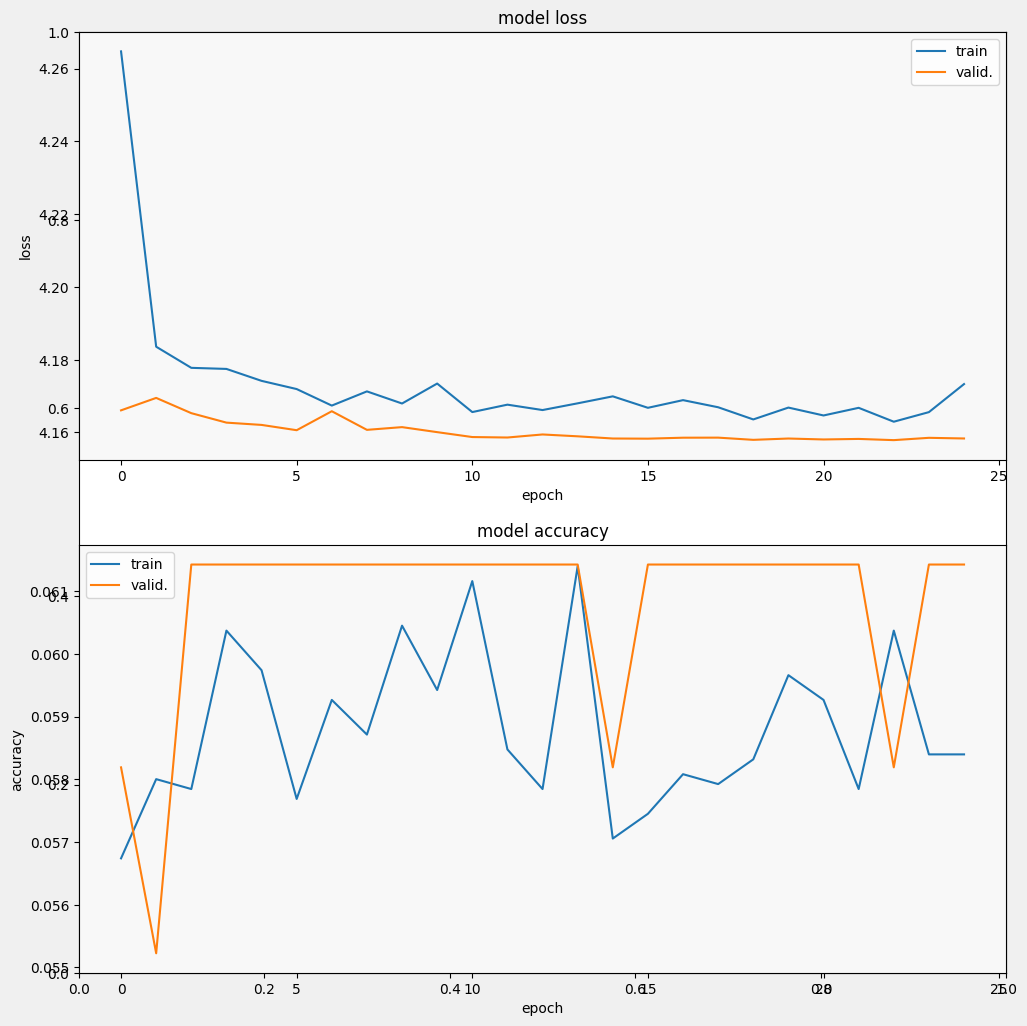

In [16]:
with strategy.scope():    
    
    #VGG16 
    # Define the model as a sequential sequence of layers
    vgg16_model = Sequential()

    # Define convolutional layers
    vgg16_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(*IMAGE_SIZE, 3)))
    vgg16_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    vgg16_model.add(MaxPooling2D((2, 2)))

    vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    vgg16_model.add(MaxPooling2D((2, 2)))

    vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    vgg16_model.add(MaxPooling2D((2, 2)))

    vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    vgg16_model.add(MaxPooling2D((2, 2)))

    vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    vgg16_model.add(MaxPooling2D((2, 2)))

    # Define classification layers
    vgg16_model.add(Flatten())
    vgg16_model.add(Dense(4096, activation='relu'))
    vgg16_model.add(Dropout(0.5))
    vgg16_model.add(Dense(4096, activation='relu'))
    vgg16_model.add(Dropout(0.5))
    vgg16_model.add(Dense(len(CLASSES), activation='softmax'))

    # Print a summary of the model architecture
    print(vgg16_model.summary())

      
vgg16_model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


start_time = time.time()
vgg16_model_history = vgg16_model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset)
end_time = time.time()
model_training_time.append(end_time-start_time)
model_names.append('vgg16_model')

display_training_curves(
    vgg16_model_history.history['loss'],
    vgg16_model_history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    vgg16_model_history.history['sparse_categorical_accuracy'],
    vgg16_model_history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

train_accuracy.append(vgg16_model_history.history['sparse_categorical_accuracy'][-1])
val_accuracy.append(vgg16_model_history.history['val_sparse_categorical_accuracy'][-1])

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_13 (Dense)            (None, 104)               53352     
                                                                 
Total params: 14768040 (56.34 MB)
Trainable params: 53352 (208.41 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
None
Epoch 1/25


2023-11-12 21:06:10.164284: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


99/99 [==============================] - 19s 122ms/step - loss: 3.9980 - sparse_categorical_accuracy: 0.1139 - val_loss: 3.6981 - val_sparse_categorical_accuracy: 0.1832
Epoch 2/25
99/99 [==============================] - 6s 63ms/step - loss: 3.5109 - sparse_categorical_accuracy: 0.2161 - val_loss: 3.3544 - val_sparse_categorical_accuracy: 0.2503
Epoch 3/25
99/99 [==============================] - 6s 63ms/step - loss: 3.2049 - sparse_categorical_accuracy: 0.2735 - val_loss: 3.1039 - val_sparse_categorical_accuracy: 0.2923
Epoch 4/25
99/99 [==============================] - 6s 63ms/step - loss: 2.9786 - sparse_categorical_accuracy: 0.3264 - val_loss: 2.9116 - val_sparse_categorical_accuracy: 0.3392
Epoch 5/25
99/99 [==============================] - 6s 64ms/step - loss: 2.7906 - sparse_categorical_accuracy: 0.3673 - val_loss: 2.7579 - val_sparse_categorical_accuracy: 0.3753
Epoch 6/25
99/99 [==============================] - 6s 63ms/step - loss: 2.6355 - sparse_categorical_accuracy: 0.4

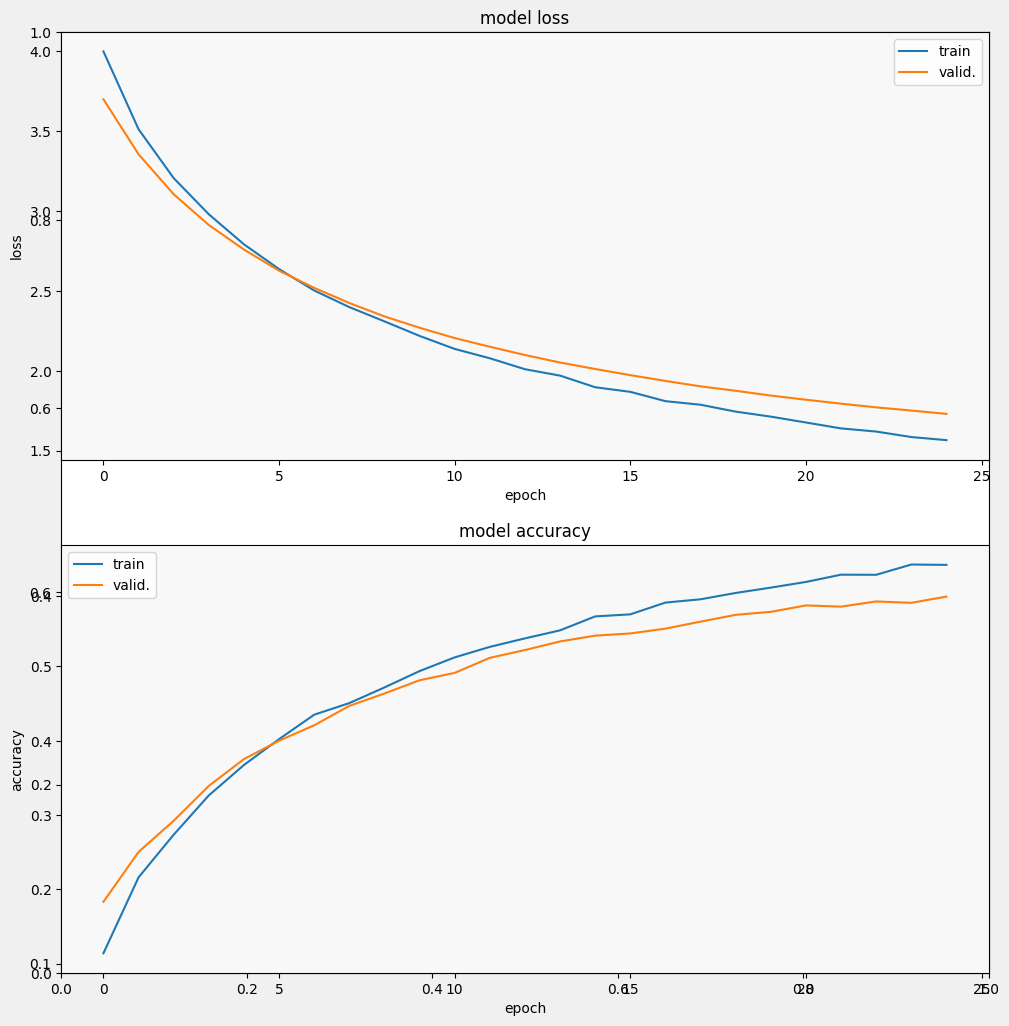

In [17]:
with strategy.scope():    
    pretrained_VGG16 = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_VGG16.trainable = False
    
    pretrained_VGG16_model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_VGG16,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    print(pretrained_VGG16_model.summary())

pretrained_VGG16_model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

start_time = time.time()
pretrained_VGG16_model_history = pretrained_VGG16_model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset)
end_time = time.time()
model_training_time.append(end_time-start_time)
model_names.append('pretrained_VGG16_model')

display_training_curves(
    pretrained_VGG16_model_history.history['loss'],
    pretrained_VGG16_model_history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    pretrained_VGG16_model_history.history['sparse_categorical_accuracy'],
    pretrained_VGG16_model_history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)
train_accuracy.append(pretrained_VGG16_model_history.history['sparse_categorical_accuracy'][-1])
val_accuracy.append(pretrained_VGG16_model_history.history['val_sparse_categorical_accuracy'][-1])

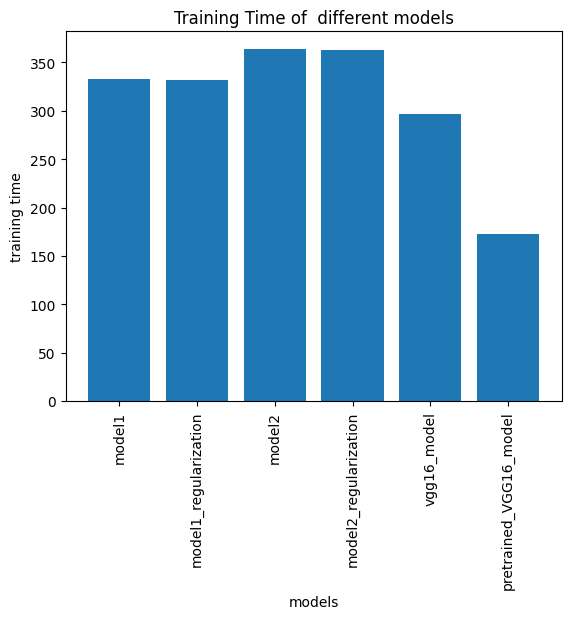

In [18]:
display_training_time_plot(model_names, model_training_time)

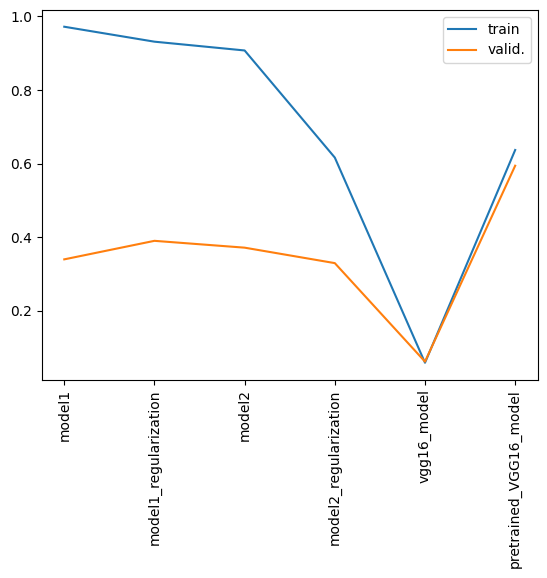

In [19]:
display_accuracy_plot(model_names, train_accuracy, val_accuracy)

In [ ]:
#saving predictions from model2
test_images_ds = test_dataset.map(lambda image, idnum: image)
probabilities = model1_regularization.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)



In [21]:
test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
print('submission.csv file saved')

submission.csv file saved
